# SPIDS Microscopy: Resolving Beyond the Diffraction Limit

**Duration**: 45-60 minutes  
**Level**: Intermediate  
**Prerequisites**: Basic optics knowledge, familiarity with SPIDS concepts

---

## Learning Objectives

By the end of this notebook, you will:

1. **Understand** the fundamental resolution limit of conventional microscopy (Abbe diffraction limit)
2. **Simulate** a low-magnification microscope system and observe its resolution limitations
3. **Apply** SPIDS reconstruction using `ProgressiveDecoder` to iteratively recover the target
4. **Demonstrate** how synthetic aperture construction extends effective NA
5. **Compare** conventional microscopy vs SPIDS reconstruction quantitatively

---

## What This Notebook Does

This notebook demonstrates **actual SPIDS reconstruction** using the same forward model as conventional microscopy:

1. **Conventional Imaging**: Simulate a 20x/0.1 NA microscope imaging a USAF target
2. **SPIDS Reconstruction**: Use `ProgressiveDecoder` with `MeasurementSystem` to progressively reconstruct the target from k-space sub-aperture measurements
3. **Comparison**: Quantitatively compare resolution enhancement

The key insight is that both conventional microscopy and SPIDS use the same Fourier optics forward model (FFT → aperture → FFT → intensity). SPIDS extends the effective aperture by combining multiple sub-aperture measurements.

---

# Part 1: Theoretical Background

## 1.1 The Abbe Diffraction Limit

When light passes through a lens with finite numerical aperture (NA), high spatial frequencies are filtered out. The **cutoff frequency** in k-space is:

$$f_{cutoff} = \frac{\text{NA}}{\lambda}$$

This defines a circular region in k-space that can be captured by the optical system.

### Resolution Formula (Abbe Criterion)

$$\Delta x = \frac{0.61\lambda}{\text{NA}}$$

For a 20x/0.1 NA objective at 550 nm wavelength: Δx ≈ 3355 nm

## 1.2 The Pupil Plane IS K-Space

**This is the key theoretical insight:** In a coherent imaging system, the **pupil plane** (back focal plane of the objective) is mathematically equivalent to **k-space** (Fourier space).

### Why are they the same?

The objective lens performs a **Fourier transform** from object space to its back focal plane:

$$\tilde{E}(k_x, k_y) = \mathcal{F}\{E(x, y)\}$$

where:
- $E(x, y)$ is the object field (spatial domain)
- $\tilde{E}(k_x, k_y)$ is the field at the pupil plane (frequency domain)
- $k_x, k_y$ are spatial frequencies: $k = \frac{2\pi}{\lambda} \sin\theta$

### Physical interpretation

| Location | What it represents |
|----------|-------------------|
| Object plane | Spatial information (where features are) |
| Pupil plane = k-space | Frequency information (how fine features are) |
| DC (center of pupil) | Low frequencies = coarse features |
| Edge of pupil | High frequencies = fine features |
| Outside pupil | Frequencies beyond NA cutoff = lost |

### The NA defines the k-space cutoff

The objective's NA physically limits which angles (frequencies) can enter:

$$\text{NA} = n \sin\theta_{max} \quad \Rightarrow \quad k_{max} = \frac{\text{NA}}{\lambda}$$

Any object features with spatial frequencies $k > k_{max}$ are **physically blocked** by the finite pupil aperture.

## 1.3 SPIDS: Scanning in the Pupil = Scanning K-Space

Since the pupil plane IS k-space, when we position an aperture at different locations in the pupil plane, we are sampling different regions of the object's frequency spectrum.

### Conventional imaging
- Aperture centered at DC (k=0)
- Captures frequencies from $-k_{aperture}$ to $+k_{aperture}$
- Resolution limited by aperture size

### SPIDS scanning
- **Same aperture**, moved to position $(k_x, k_y)$ in the pupil
- Captures frequencies from $(k_x - R)$ to $(k_x + R)$ where R is aperture radius
- By scanning to multiple positions, we sample more of k-space

### Mathematical equivalence

```
Object → [Objective Lens] → Pupil Plane → [Tube Lens] → Image
         (Fourier Transform)  (k-space)   (Inverse FT)

In simulation:
Object → FFT → Apply aperture mask → IFFT → Image
```

The aperture mask in the pupil plane directly filters spatial frequencies. Moving the aperture shifts which frequencies pass through.

## 1.4 Building the Synthetic Aperture

| | Conventional | SPIDS |
|--|--|--|
| **Aperture size** | R (pupil radius) | **Same R** (identical!) |
| **Aperture position** | Centered at DC | Scanned across pupil plane |
| **K-space region sampled** | Circle of radius R at origin | Multiple circles at different positions |
| **Effective k-space coverage** | $\pi R^2$ | Union of all circles ≈ $\pi(R_{scan} + R)^2$ |

**Key insight:** The synthetic aperture is the **union** of all sampled k-space regions. By scanning the **same** aperture to positions beyond the original DC location, we capture frequencies that would normally be blocked, achieving super-resolution.

## 1.5 Forward Model Implementation

Both conventional and SPIDS use identical physics:

```python
# Forward model (same for both)
field_kspace = torch.fft.fftshift(torch.fft.fft2(object_field))  # To pupil/k-space
field_filtered = field_kspace * aperture_mask                    # Apply aperture
image = torch.abs(torch.fft.ifft2(torch.fft.ifftshift(field_filtered)))**2  # To image

# Conventional: aperture_mask centered at DC
# SPIDS: aperture_mask at various (kx, ky) positions (SAME SIZE aperture!)
```

The only difference is **where** the aperture is positioned in the pupil plane (k-space). The aperture **size** is identical.

---

# Part 2: Setup and Configuration

Let's set up our simulation environment and define the microscope parameters.

In [75]:
# Standard library imports
import warnings
from datetime import datetime

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.patches import Circle

# SPIDS imports - Core
from prism.core import MeasurementSystem, create_usaf_target
from prism.core.instruments import Microscope, MicroscopeConfig
from prism.core.patterns import generate_fermat_spiral

# SPIDS imports - Models and Training
from prism.models.networks import ProgressiveDecoder
from prism.utils.metrics import compute_ssim, psnr


# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Set matplotlib style
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["image.cmap"] = "gray"

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Notebook started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nSetup complete!")

Using device: cuda
Notebook started: 2025-11-27 19:15:37

Setup complete!


## 2.1 Microscope and SPIDS Configuration

We configure:
1. **Microscope parameters**: 20x/0.1 NA air objective
2. **SPIDS parameters**: Fixed synthetic aperture radius (120px), sub-aperture size, number of scan positions

### Why Pupil Plane = K-Space (No Transformation Needed!)

This is the fundamental insight: **scanning in the pupil plane IS scanning in k-space** - they are the same thing.

In a coherent imaging system, the objective lens performs a **spatial Fourier transform**:
- Light from the object at angle θ focuses to position $k = \frac{2\pi}{\lambda}\sin\theta$ in the pupil plane
- The pupil plane coordinates (x_pupil, y_pupil) directly map to spatial frequencies (k_x, k_y)
- An aperture at position (k_x, k_y) in the pupil passes light from that region of k-space

**No coordinate transformation is needed** because the lens itself performs the Fourier transform optically. When we move an aperture in the pupil plane, we are literally selecting different spatial frequency content from the object.

### Configuration Summary
- **Conventional microscopy**: Sub-aperture (R = 15px) centered at DC → captures frequencies |k| < k_max
- **SPIDS**: Same sub-aperture (R = 15px) scanned to build a synthetic aperture of 120px radius

In [76]:
# =============================================================================
# MICROSCOPE CONFIGURATION
# =============================================================================
# Using a low-NA objective to demonstrate resolution enhancement

WAVELENGTH = 550e-9  # 550 nm (green light)
N_PIXELS = 256  # Grid size (smaller for faster training)

# Create microscope configuration
# 20x/0.1 NA air objective - typical for low-mag overview imaging
microscope_config = MicroscopeConfig(
    n_pixels=N_PIXELS,
    numerical_aperture=0.1,
    magnification=20.0,
    wavelength=WAVELENGTH,
    pixel_size=6.5e-6,  # 6.5 µm sensor pixels
    medium_index=1.0,  # Air
)

# Create microscope instance
microscope = Microscope(microscope_config)

# Get key parameters
na_low = microscope.na
resolution_low_nm = microscope.resolution_limit * 1e9  # Convert to nm
object_pixel_size = microscope_config.pixel_size / microscope.magnification
field_of_view = N_PIXELS * object_pixel_size

print("=" * 70)
print("MICROSCOPE CONFIGURATION")
print("=" * 70)
print(f"\nObjective: 20x / {na_low} NA air")
print(f"Wavelength: {WAVELENGTH * 1e9:.0f} nm")
print("\nComputed Parameters:")
print(f"  Lateral Resolution (Abbe): {resolution_low_nm:.0f} nm")
print(f"  Object Pixel Size: {object_pixel_size * 1e9:.1f} nm")
print(f"  Field of View: {field_of_view * 1e6:.1f} µm")
print(f"  Pupil Radius (pixels): {microscope.pupil_radius_pixels:.1f}")
print("=" * 70)

MICROSCOPE CONFIGURATION

Objective: 20x / 0.1 NA air
Wavelength: 550 nm

Computed Parameters:
  Lateral Resolution (Abbe): 3355 nm
  Object Pixel Size: 325.0 nm
  Field of View: 83.2 µm
  Pupil Radius (pixels): 15.1


In [77]:
# =============================================================================
# SPIDS RECONSTRUCTION CONFIGURATION
# =============================================================================

# THE KEY INSIGHT:
# - Conventional microscopy: Uses aperture of radius R centered at DC
# - SPIDS: Uses the SAME aperture (radius R), but scans it to different k-space positions
# - Synthetic aperture = union of all scanned positions

# Target synthetic aperture radius (fixed, determines final resolution)
SYNTHETIC_APERTURE_RADIUS = 55  # pixels - this is our target k-space coverage

# Get the full NA pupil radius - this is the sub-aperture we use for each scan
FULL_PUPIL_RADIUS = microscope.pupil_radius_pixels  # ~15 pixels for NA=0.1

# Both conventional and SPIDS use the same sub-aperture size
SUB_APERTURE_RADIUS = FULL_PUPIL_RADIUS  # ~15 px for each measurement
CONVENTIONAL_APERTURE_RADIUS = SUB_APERTURE_RADIUS  # Same aperture at DC for conventional

# How far do we scan the aperture center from DC?
# To achieve synthetic aperture R_synth, we scan centers out to R_synth - R_sub
SCAN_RADIUS = SYNTHETIC_APERTURE_RADIUS - SUB_APERTURE_RADIUS

# Effective synthetic aperture = SCAN_RADIUS + SUB_APERTURE_RADIUS = SYNTHETIC_APERTURE_RADIUS
effective_synthetic_radius = SCAN_RADIUS + SUB_APERTURE_RADIUS

# Number of scan positions (more needed for larger scan radius)
N_SAMPLES = 25

# Training configuration
LEARNING_RATE = 0.001
MAX_EPOCHS_INIT = 1000
MAX_EPOCHS_PER_SAMPLE = 1000
LOSS_THRESHOLD = 0.001

# Calculate effective NAs
# Conventional: aperture at DC captures up to SUB_APERTURE_RADIUS in k-space
conventional_effective_na = na_low  # NA=0.1 for conventional
# SPIDS: synthetic aperture extends to SYNTHETIC_APERTURE_RADIUS
synthetic_effective_na = effective_synthetic_radius / FULL_PUPIL_RADIUS * na_low
conventional_resolution_nm = 0.61 * WAVELENGTH * 1e9 / conventional_effective_na
effective_resolution_nm = 0.61 * WAVELENGTH * 1e9 / synthetic_effective_na

print("=" * 70)
print("SPIDS CONFIGURATION (Same Aperture, Extended Coverage)")
print("=" * 70)
print(f"\nTarget synthetic aperture: {SYNTHETIC_APERTURE_RADIUS} px")
print(f"Microscope pupil radius: {FULL_PUPIL_RADIUS:.1f} px (NA={na_low})")
print("\nBOTH methods use the SAME sub-aperture:")
print(f"  Sub-aperture radius: {SUB_APERTURE_RADIUS:.1f} px")
print(f"  Conventional resolution: {conventional_resolution_nm:.0f} nm")
print("\nSPIDS scanning configuration:")
print(f"  Scan radius (center positions): {SCAN_RADIUS:.1f} px from DC")
print(f"  Synthetic aperture radius: {effective_synthetic_radius:.1f} px")
print(f"  Number of scans: {N_SAMPLES}")
print("\nExpected Enhancement:")
print(f"  Conventional NA: {conventional_effective_na:.2f}")
print(f"  SPIDS synthetic NA: {synthetic_effective_na:.2f}")
print(
    f"  Resolution improvement: {conventional_resolution_nm:.0f} nm -> {effective_resolution_nm:.0f} nm"
)
print(f"  Enhancement factor: {conventional_resolution_nm / effective_resolution_nm:.1f}x")
print("=" * 70)

SPIDS CONFIGURATION (Same Aperture, Extended Coverage)

Target synthetic aperture: 55 px
Microscope pupil radius: 15.1 px (NA=0.1)

BOTH methods use the SAME sub-aperture:
  Sub-aperture radius: 15.1 px
  Conventional resolution: 3355 nm

SPIDS scanning configuration:
  Scan radius (center positions): 39.9 px from DC
  Synthetic aperture radius: 55.0 px
  Number of scans: 25

Expected Enhancement:
  Conventional NA: 0.10
  SPIDS synthetic NA: 0.36
  Resolution improvement: 3355 nm -> 923 nm
  Enhancement factor: 3.6x


## 2.2 Create Resolution Test Target

We'll use a **USAF-1951 resolution test target** with groups chosen to span the resolution limit of our low-NA objective.

The USAF-1951 target has line triplets with known spatial frequencies:
- **Group 4**: ~5.6-11.3 lp/mm (bar widths ~45-89 µm)
- **Group 5**: ~11.3-22.6 lp/mm (bar widths ~22-44 µm)
- **Group 6**: ~22.6-45.2 lp/mm (bar widths ~11-22 µm)
- **Group 7**: ~45.2-90.5 lp/mm (bar widths ~5.5-11 µm)

Given our ~1.1 µm resolution limit, we'll include groups where:
- Lower groups (4-5): Should be clearly resolved
- Higher groups (6-7): Near or beyond resolution limit

In [78]:
# Create USAF-1951 target
# IMPORTANT: Match target FOV to microscope scenario FOV exactly
# Mismatch causes FFT wraparound artifacts ("plaid" pattern)

# Create target with automatic group selection based on field size
target = create_usaf_target(
    field_size=field_of_view,
    resolution=N_PIXELS,
    groups=None,  # Auto-select groups based on field size
    margin_ratio=0.25,  # 25% margin on each side for proper diffraction
)

# Generate ground truth image
ground_truth = target.generate().to(device)

print("\nUSAF-1951 Target Created:")
print(f"  Field Size: {field_of_view * 1e6:.1f} µm")
print(f"  Resolution: {N_PIXELS} x {N_PIXELS} pixels")
print(f"  Pixel Size: {target.config.pixel_size * 1e9:.1f} nm")
print(f"  Active Region: {target.config.active_size} x {target.config.active_size} pixels")
print(f"  Active Field Size: {target.config.active_field_size * 1e6:.1f} µm")
print(f"  Groups Included: {target.usaf_config.groups}")

# Check which elements are resolvable
resolvable = target.get_resolvable_elements(resolution_low_nm * 1e-9, unit="m")
print(f"\nResolvable Elements at {resolution_low_nm:.0f} nm:")
if resolvable:
    for group, element in resolvable[:3]:  # Show first 3
        bar_width_nm = target.get_bar_width_m(group, element) * 1e9
        print(f"  Group {group}, Element {element}: {bar_width_nm:.0f} nm bars")
    if len(resolvable) > 3:
        print(f"  ... and {len(resolvable) - 3} more")
else:
    print("  No elements resolvable at this resolution")


USAF-1951 Target Created:
  Field Size: 83.2 µm
  Resolution: 256 x 256 pixels
  Pixel Size: 325.0 nm
  Active Region: 128 x 128 pixels
  Active Field Size: 41.6 µm
  Groups Included: (8, 9)

Resolvable Elements at 3355 nm:
  No elements resolvable at this resolution


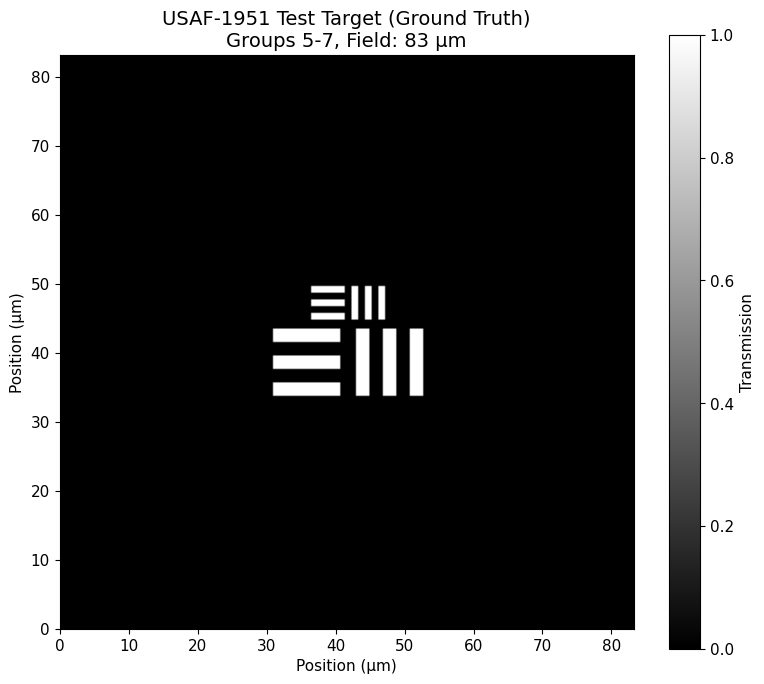

This is the 'ideal' target that we want to reconstruct.


In [79]:
# Visualize the ground truth target
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

extent = [0, field_of_view * 1e6, 0, field_of_view * 1e6]  # µm
im = ax.imshow(ground_truth.cpu().numpy(), cmap="gray", extent=extent, origin="lower")
ax.set_title(
    f"USAF-1951 Test Target (Ground Truth)\nGroups 5-7, Field: {field_of_view * 1e6:.0f} µm",
    fontsize=14,
)
ax.set_xlabel("Position (µm)")
ax.set_ylabel("Position (µm)")
plt.colorbar(im, ax=ax, label="Transmission", shrink=0.8)

plt.tight_layout()
plt.show()

print("This is the 'ideal' target that we want to reconstruct.")

---

# Part 3: Conventional Microscopy Simulation

Now let's simulate what the low-NA microscope actually sees. Due to the diffraction limit, fine features will be blurred.

In [80]:
# Simulate conventional microscopy with the SAME aperture that SPIDS will use
# The only difference: conventional uses aperture centered at DC
print("Simulating conventional microscopy...")

# Prepare input field
input_field = ground_truth.unsqueeze(0).unsqueeze(0)

# Forward through microscope using the aperture centered at DC
# This is standard brightfield imaging with the full NA
with torch.no_grad():
    conventional_measurement = microscope.forward(
        input_field,
        aperture_center=[0.0, 0.0],  # Centered at DC
        aperture_radius=CONVENTIONAL_APERTURE_RADIUS,  # Same aperture as SPIDS
        input_mode="intensity",
        input_pixel_size=target.config.pixel_size,
    )

# Remove batch/channel dimensions
conventional_2d = conventional_measurement.squeeze().cpu().numpy()

print("\nConventional measurement complete.")
print(f"  Aperture: {CONVENTIONAL_APERTURE_RADIUS:.1f} px radius at DC")
print(f"  Effective NA: {conventional_effective_na:.2f}")
print(f"  Resolution: {conventional_resolution_nm:.0f} nm")

Simulating conventional microscopy...

Conventional measurement complete.
  Aperture: 15.1 px radius at DC
  Effective NA: 0.10
  Resolution: 3355 nm


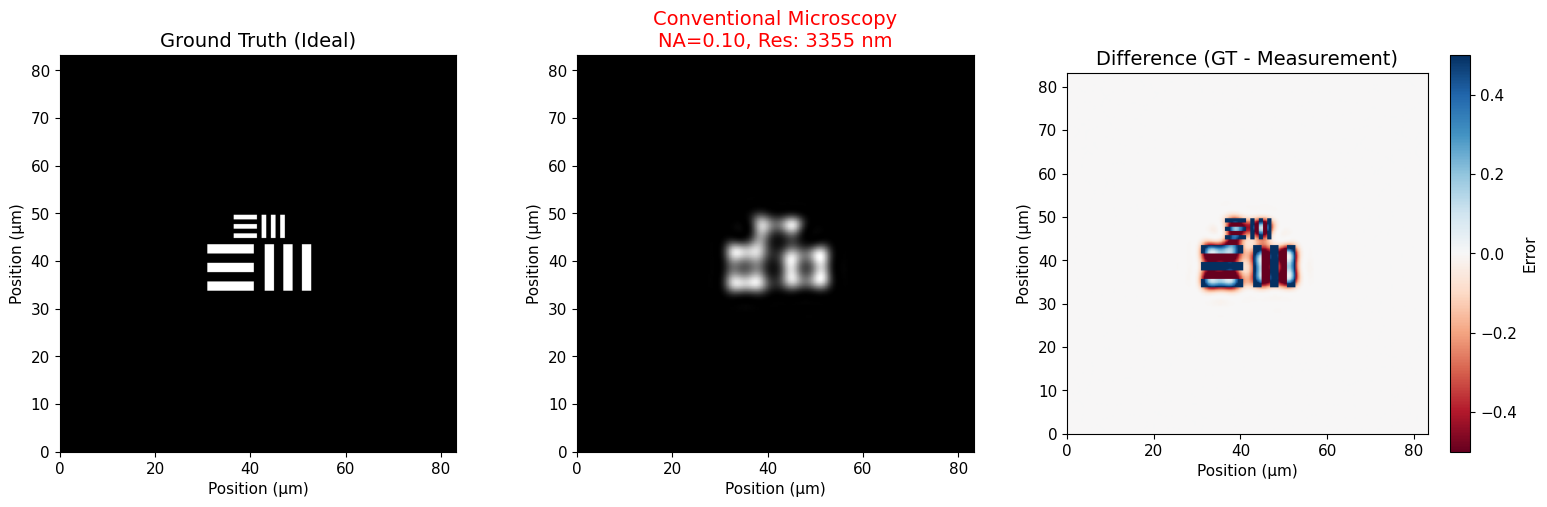


CONVENTIONAL IMAGING METRICS (computed on center crop)
  Aperture: 15 px at DC
  Effective NA: 0.10
  Resolution: 3355 nm
  Crop size: 128x128 px (excludes black background)
  SSIM: 0.7200
  PSNR: 13.28 dB

Note: Metrics computed on cropped region to avoid inflated scores from
matching black background. This better reflects actual target reconstruction.

SPIDS will use the SAME aperture, but scan it to build a larger synthetic aperture.


In [81]:
# Compare ground truth with conventional microscopy measurement
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Ground truth
axes[0].imshow(ground_truth.cpu().numpy(), cmap="gray", extent=extent, origin="lower")
axes[0].set_title("Ground Truth (Ideal)", fontsize=14)
axes[0].set_xlabel("Position (µm)")
axes[0].set_ylabel("Position (µm)")

# Conventional measurement
axes[1].imshow(conventional_2d, cmap="gray", extent=extent, origin="lower")
axes[1].set_title(
    f"Conventional Microscopy\nNA={conventional_effective_na:.2f}, Res: {conventional_resolution_nm:.0f} nm",
    fontsize=14,
    color="red",
)
axes[1].set_xlabel("Position (µm)")
axes[1].set_ylabel("Position (µm)")

# Difference (error)
gt_norm = ground_truth.cpu().numpy()
gt_norm = (gt_norm - gt_norm.min()) / (gt_norm.max() - gt_norm.min() + 1e-8)
meas_norm = (conventional_2d - conventional_2d.min()) / (
    conventional_2d.max() - conventional_2d.min() + 1e-8
)
diff = gt_norm - meas_norm

im = axes[2].imshow(diff, cmap="RdBu", extent=extent, origin="lower", vmin=-0.5, vmax=0.5)
axes[2].set_title("Difference (GT - Measurement)", fontsize=14)
axes[2].set_xlabel("Position (µm)")
axes[2].set_ylabel("Position (µm)")
plt.colorbar(im, ax=axes[2], label="Error")

plt.tight_layout()
plt.show()

# Define crop region for metrics (same as zoomed view) - excludes black background
# This gives more meaningful metrics by focusing on the actual target features
METRIC_CROP_SIZE = N_PIXELS // 2  # Use active region size (128px for 256px image)

# Compute quality metrics on CROPPED region (more meaningful for sparse targets)
ssim_conventional = compute_ssim(
    torch.tensor(meas_norm), torch.tensor(gt_norm), size=METRIC_CROP_SIZE
)
psnr_conventional = psnr(torch.tensor(meas_norm), torch.tensor(gt_norm), size=METRIC_CROP_SIZE)

print("\n" + "=" * 60)
print("CONVENTIONAL IMAGING METRICS (computed on center crop)")
print("=" * 60)
print(f"  Aperture: {CONVENTIONAL_APERTURE_RADIUS:.0f} px at DC")
print(f"  Effective NA: {conventional_effective_na:.2f}")
print(f"  Resolution: {conventional_resolution_nm:.0f} nm")
print(f"  Crop size: {METRIC_CROP_SIZE}x{METRIC_CROP_SIZE} px (excludes black background)")
print(f"  SSIM: {ssim_conventional:.4f}")
print(f"  PSNR: {psnr_conventional:.2f} dB")
print("=" * 60)
print("\nNote: Metrics computed on cropped region to avoid inflated scores from")
print("matching black background. This better reflects actual target reconstruction.")
print("\nSPIDS will use the SAME aperture, but scan it to build a larger synthetic aperture.")

## 3.1 Understanding the Resolution Limit

The PSF width defines the smallest resolvable feature. For our 20x/0.1 NA objective, this is ~3355 nm.

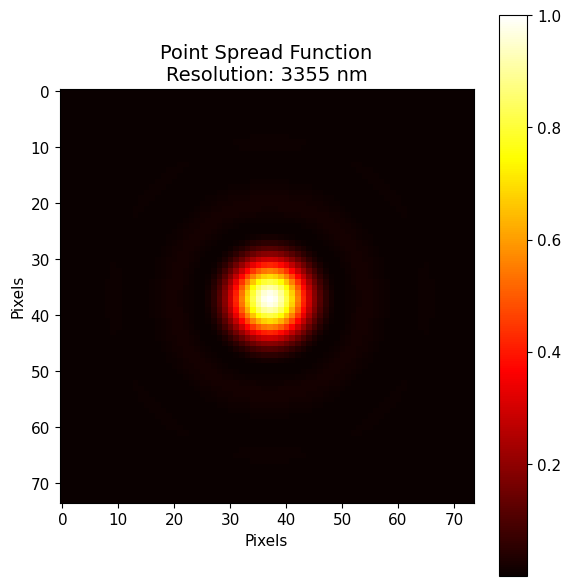

The PSF width (~3355 nm) limits conventional resolution.


In [82]:
# Simplified PSF visualization
psf = microscope.compute_psf(illumination_mode="brightfield")
psf_centered = torch.fft.fftshift(psf).cpu().numpy()

# Show PSF - crop size scales with pupil radius for consistent visualization
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
center = psf_centered.shape[0] // 2
# Use dynamic crop based on pupil radius (show ~2.5x the PSF extent)
crop = max(20, int(FULL_PUPIL_RADIUS * 2.5))
psf_crop = psf_centered[center - crop : center + crop, center - crop : center + crop]

im = ax.imshow(psf_crop, cmap="hot")
ax.set_title(f"Point Spread Function\nResolution: {resolution_low_nm:.0f} nm", fontsize=14)
ax.set_xlabel("Pixels")
ax.set_ylabel("Pixels")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

print(f"The PSF width (~{resolution_low_nm:.0f} nm) limits conventional resolution.")

The k-space (Fourier domain) representation shows what spatial frequencies are captured. The conventional pupil limits this to a small region around DC.

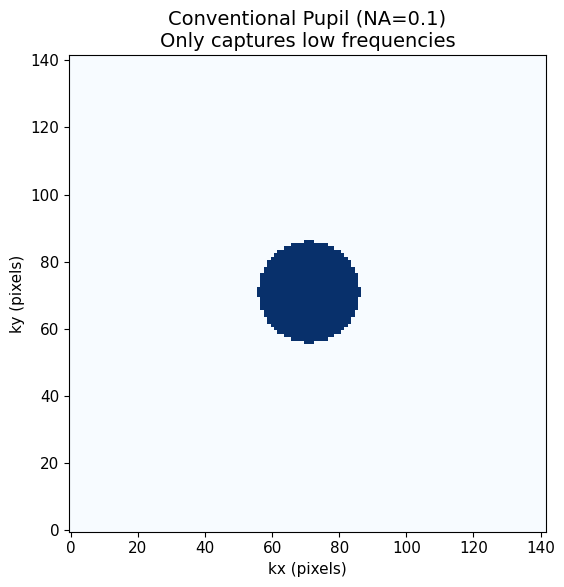

Pupil radius: 15.1 pixels
Frequencies outside this pupil are lost in conventional imaging.


In [83]:
# Show conventional pupil in k-space
pupil = microscope.generate_aperture_mask([0, 0]).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# Use dynamic crop based on effective synthetic radius for consistent visualization
kspace_crop = int(effective_synthetic_radius * 1.3)
center_crop = slice(N_PIXELS // 2 - kspace_crop, N_PIXELS // 2 + kspace_crop)
ax.imshow(pupil[center_crop, center_crop], cmap="Blues", origin="lower")
ax.set_title(f"Conventional Pupil (NA={na_low})\nOnly captures low frequencies", fontsize=14)
ax.set_xlabel("kx (pixels)")
ax.set_ylabel("ky (pixels)")
plt.tight_layout()
plt.show()

print(f"Pupil radius: {microscope.pupil_radius_pixels:.1f} pixels")
print("Frequencies outside this pupil are lost in conventional imaging.")

---

# Part 4: SPIDS Progressive Reconstruction

Now we apply the actual SPIDS algorithm using:
1. **MeasurementSystem**: Wraps the microscope, tracks cumulative k-space mask
2. **ProgressiveDecoder**: Neural network that generates reconstruction from learned latent
3. **LossAgg**: Computes loss against both old (accumulated) and new measurements
4. **Fermat Spiral**: Optimal k-space sampling pattern

The key insight is that each measurement constrains the reconstruction to match the k-space content at that position, while maintaining consistency with all previous measurements.

## 4.1 Initialize SPIDS Components

We set up:
- `MeasurementSystem`: Wraps microscope, manages cumulative mask
- `ProgressiveDecoder`: Generates reconstruction from learned latent
- `LossAgg`: Computes progressive loss
- `Fermat spiral`: Sampling pattern for k-space

In [84]:
# =============================================================================
# INITIALIZE SPIDS COMPONENTS
# =============================================================================

# 1. Create MeasurementSystem wrapping the microscope
measurement_system = MeasurementSystem(microscope)
measurement_system.to(device)

print("MeasurementSystem created")
print(f"  Instrument: {type(measurement_system.instrument).__name__}")

# 2. Create ProgressiveDecoder model
model = ProgressiveDecoder(
    input_size=N_PIXELS,
    output_size=N_PIXELS,
    use_bn=True,
).to(device)

print(f"ProgressiveDecoder created (output: {N_PIXELS}x{N_PIXELS})")

# 3. Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Optimizer: Adam (lr={LEARNING_RATE})")

# 4. Generate Fermat spiral - scan positions for the aperture center
sample_centers = generate_fermat_spiral(
    n_points=N_SAMPLES,
    r_max=SCAN_RADIUS,  # How far centers go from DC
    length=0,
)
centers_np = sample_centers.squeeze().numpy()

print(f"\nScan pattern: Fermat spiral with {N_SAMPLES} positions")
print(f"  Aperture centers scan out to {SCAN_RADIUS:.0f} pixels from DC")

MeasurementSystem created
  Instrument: Microscope
ProgressiveDecoder created (output: 256x256)
Optimizer: Adam (lr=0.001)

Scan pattern: Fermat spiral with 25 positions
  Aperture centers scan out to 40 pixels from DC


## 4.2 Visualize Sampling Pattern

The Fermat spiral provides optimal k-space coverage with the golden angle (~137.5°) between successive points.

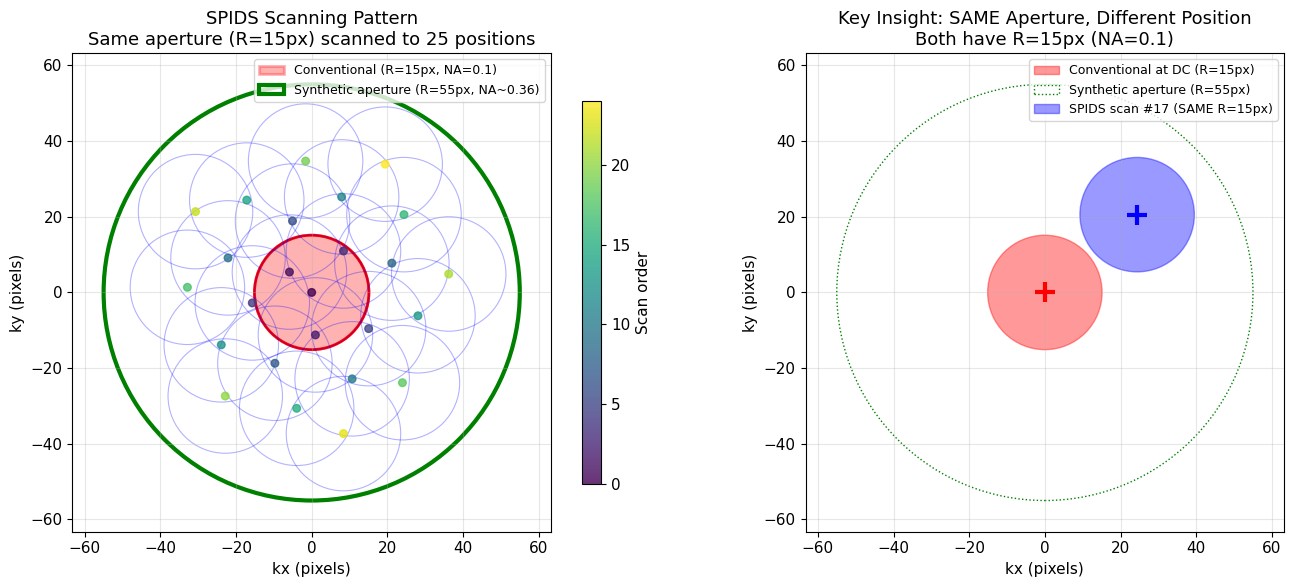


Key insight:
  - Aperture radius: 55px (NA=0.1)
  - Conventional: This aperture at DC only
  - SPIDS: SAME aperture scanned to 25 positions
  - Synthetic aperture: 55px (NA~0.36)
  - Resolution enhancement: 3355nm -> 923nm (3.6x)


In [85]:
# Visualize the scanning pattern - SAME aperture scanned to different positions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]

# Draw the conventional aperture (red) - centered at DC
# This is what conventional microscopy captures
conv_circle = Circle(
    (0, 0),
    CONVENTIONAL_APERTURE_RADIUS,
    fill=True,
    color="red",
    alpha=0.3,
    linewidth=2,
    label=f"Conventional (R={CONVENTIONAL_APERTURE_RADIUS:.0f}px, NA={na_low})",
)
ax.add_patch(conv_circle)
conv_edge = Circle((0, 0), CONVENTIONAL_APERTURE_RADIUS, fill=False, color="red", linewidth=2)
ax.add_patch(conv_edge)

# Draw the synthetic aperture boundary (green)
synth_circle = Circle(
    (0, 0),
    effective_synthetic_radius,
    fill=False,
    color="green",
    linewidth=3,
    linestyle="-",
    label=f"Synthetic aperture (R={effective_synthetic_radius:.0f}px, NA~{synthetic_effective_na:.2f})",
)
ax.add_patch(synth_circle)

# Draw each scanned aperture position (blue circles - SAME SIZE as conventional!)
for i, (y, x) in enumerate(centers_np):
    circle = Circle((x, y), SUB_APERTURE_RADIUS, fill=False, color="blue", alpha=0.3, linewidth=0.8)
    ax.add_patch(circle)

# Draw scan center positions
scatter = ax.scatter(
    centers_np[:, 1],
    centers_np[:, 0],
    c=np.arange(N_SAMPLES),
    cmap="viridis",
    s=30,
    alpha=0.8,
    zorder=3,
)

# Formatting
lim = effective_synthetic_radius * 1.15
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_aspect("equal")
ax.set_title(
    f"SPIDS Scanning Pattern\nSame aperture (R={SUB_APERTURE_RADIUS:.0f}px) scanned to {N_SAMPLES} positions",
    fontsize=13,
)
ax.set_xlabel("kx (pixels)")
ax.set_ylabel("ky (pixels)")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label="Scan order", shrink=0.8)

# Right: Show comparison - conventional vs one SPIDS scan
ax2 = axes[1]

# Conventional aperture at center
conv = Circle(
    (0, 0),
    CONVENTIONAL_APERTURE_RADIUS,
    fill=True,
    color="red",
    alpha=0.4,
    label=f"Conventional at DC (R={CONVENTIONAL_APERTURE_RADIUS:.0f}px)",
)
ax2.add_patch(conv)

# Synthetic aperture boundary (reference)
synth_ref = Circle(
    (0, 0),
    effective_synthetic_radius,
    fill=False,
    color="green",
    linewidth=1,
    linestyle=":",
    label=f"Synthetic aperture (R={effective_synthetic_radius:.0f}px)",
)
ax2.add_patch(synth_ref)

# One example off-center aperture
idx = len(centers_np) * 2 // 3  # Pick an outer sample
off_y, off_x = centers_np[idx]
off_center = Circle(
    (off_x, off_y),
    SUB_APERTURE_RADIUS,
    fill=True,
    color="blue",
    alpha=0.4,
    label=f"SPIDS scan #{idx + 1} (SAME R={SUB_APERTURE_RADIUS:.0f}px)",
)
ax2.add_patch(off_center)

# Mark centers
ax2.plot(0, 0, "r+", markersize=15, markeredgewidth=3)
ax2.plot(off_x, off_y, "b+", markersize=15, markeredgewidth=3)

ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)
ax2.set_aspect("equal")
ax2.set_title(
    f"Key Insight: SAME Aperture, Different Position\nBoth have R={SUB_APERTURE_RADIUS:.0f}px (NA={na_low})",
    fontsize=13,
)
ax2.set_xlabel("kx (pixels)")
ax2.set_ylabel("ky (pixels)")
ax2.legend(loc="upper right", fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey insight:")
print(f"  - Aperture radius: {SYNTHETIC_APERTURE_RADIUS:.0f}px (NA={na_low})")
print("  - Conventional: This aperture at DC only")
print(f"  - SPIDS: SAME aperture scanned to {N_SAMPLES} positions")
print(
    f"  - Synthetic aperture: {effective_synthetic_radius:.0f}px (NA~{synthetic_effective_na:.2f})"
)
print(
    f"  - Resolution enhancement: {conventional_resolution_nm:.0f}nm -> {effective_resolution_nm:.0f}nm ({conventional_resolution_nm / effective_resolution_nm:.1f}x)"
)

## 4.3 Run Progressive SPIDS Reconstruction

Now we run the actual SPIDS training loop:

```
For each sub-aperture position:
    1. Generate measurement: ground_truth through new aperture
    2. Generate measurement: reconstruction through accumulated mask
    3. Train model to match BOTH measurements (LossAgg)
    4. Add aperture to cumulative mask
```

This ensures the reconstruction remains consistent with ALL previous measurements.

In [86]:
# =============================================================================
# SPIDS PROGRESSIVE RECONSTRUCTION - TRAINING LOOP
# =============================================================================

print("Starting SPIDS progressive reconstruction...")
print("=" * 70)

# History tracking
losses_history = []
ssims_history = []
psnrs_history = []
coverage_history = []

# Prepare ground truth for measurements
gt_for_meas = ground_truth
gt_amplitude = torch.sqrt(gt_for_meas.clamp(min=0))

# Loss function
loss_fn = torch.nn.L1Loss()

# Progress printing interval
PRINT_EVERY = max(1, N_SAMPLES // 10)  # Print ~10 updates

# Progressive training loop
for sample_idx, (cy, cx) in enumerate(centers_np):
    center = [float(cy), float(cx)]
    is_init = sample_idx == 0
    max_epochs = MAX_EPOCHS_INIT if is_init else MAX_EPOCHS_PER_SAMPLE

    # Generate ground truth measurement
    with torch.no_grad():
        gt_measurement = microscope.forward(
            gt_for_meas,
            aperture_center=center,
            aperture_radius=SUB_APERTURE_RADIUS,
            input_mode="intensity",
        )

    # Training loop
    best_loss = float("inf")
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        reconstruction = model()

        # New aperture loss
        rec_new_meas = microscope.forward(
            reconstruction.squeeze(),
            aperture_center=center,
            aperture_radius=SUB_APERTURE_RADIUS,
            input_mode="amplitude",
        )
        loss_new = loss_fn(rec_new_meas, gt_measurement)

        # Cumulative mask loss (for subsequent samples)
        if sample_idx > 0:
            cum_mask = measurement_system.cum_mask.to(device)
            rec_kspace = microscope.propagate_to_kspace(reconstruction.squeeze())
            rec_through_cum = microscope.propagate_to_spatial(rec_kspace * cum_mask)
            gt_kspace = microscope.propagate_to_kspace(gt_amplitude)
            gt_through_cum = microscope.propagate_to_spatial(gt_kspace * cum_mask)
            loss_old = loss_fn(rec_through_cum, gt_through_cum)
            loss = loss_old + loss_new
        else:
            loss_old = torch.tensor(0.0, device=device)
            loss = loss_new

        loss.backward()
        optimizer.step()
        if loss.item() < best_loss:
            best_loss = loss.item()

        # Check convergence
        if (
            sample_idx == 0 or loss_old.item() < LOSS_THRESHOLD
        ) and loss_new.item() < LOSS_THRESHOLD:
            break

    # Add aperture to cumulative mask
    measurement_system.add_mask([center], radius=SUB_APERTURE_RADIUS)

    # Calculate metrics on CROPPED region (consistent with conventional metrics)
    with torch.no_grad():
        rec_np = model().squeeze().cpu().numpy()
        gt_np = ground_truth.cpu().numpy()
        rec_norm = (rec_np - rec_np.min()) / (rec_np.max() - rec_np.min() + 1e-8)
        gt_norm_local = (gt_np - gt_np.min()) / (gt_np.max() - gt_np.min() + 1e-8)

        # Compute metrics on cropped region (excludes black background)
        ssim_val = compute_ssim(
            torch.tensor(rec_norm), torch.tensor(gt_norm_local), size=METRIC_CROP_SIZE
        )
        psnr_val = psnr(torch.tensor(rec_norm), torch.tensor(gt_norm_local), size=METRIC_CROP_SIZE)
        coverage = measurement_system.cum_mask.sum().item() / measurement_system.cum_mask.numel()

        losses_history.append(best_loss)
        ssims_history.append(ssim_val)
        psnrs_history.append(psnr_val)
        coverage_history.append(coverage)

    # Print progress (init phase or every N samples)
    if is_init:
        print(
            f"[INIT] Sample 1/{N_SAMPLES} | {epoch + 1} epochs | SSIM={ssim_val:.4f} PSNR={psnr_val:.1f}dB"
        )
    elif (sample_idx + 1) % PRINT_EVERY == 0 or sample_idx == N_SAMPLES - 1:
        print(
            f"Sample {sample_idx + 1}/{N_SAMPLES} | SSIM={ssim_val:.4f} PSNR={psnr_val:.1f}dB Coverage={coverage:.1%}"
        )

print("=" * 70)
print(
    f"Complete! Final: SSIM={ssims_history[-1]:.4f} PSNR={psnrs_history[-1]:.1f}dB Coverage={coverage_history[-1]:.1%}"
)
print(f"(Metrics computed on {METRIC_CROP_SIZE}x{METRIC_CROP_SIZE} center crop)")

Starting SPIDS progressive reconstruction...
[INIT] Sample 1/25 | 1000 epochs | SSIM=0.0927 PSNR=10.3dB
Sample 2/25 | SSIM=0.2538 PSNR=10.2dB Coverage=1.5%
Sample 4/25 | SSIM=0.3556 PSNR=11.7dB Coverage=2.5%
Sample 6/25 | SSIM=0.3720 PSNR=13.8dB Coverage=3.5%
Sample 8/25 | SSIM=0.5022 PSNR=16.5dB Coverage=4.4%
Sample 10/25 | SSIM=0.6096 PSNR=17.6dB Coverage=5.2%
Sample 12/25 | SSIM=0.6797 PSNR=18.4dB Coverage=6.1%
Sample 14/25 | SSIM=0.7384 PSNR=19.6dB Coverage=6.9%
Sample 16/25 | SSIM=0.7974 PSNR=22.6dB Coverage=7.7%
Sample 18/25 | SSIM=0.8411 PSNR=25.4dB Coverage=8.4%
Sample 20/25 | SSIM=0.8957 PSNR=28.0dB Coverage=9.2%
Sample 22/25 | SSIM=0.9302 PSNR=30.2dB Coverage=10.0%
Sample 24/25 | SSIM=0.9599 PSNR=32.3dB Coverage=10.7%
Sample 25/25 | SSIM=0.9675 PSNR=32.7dB Coverage=11.1%
Complete! Final: SSIM=0.9675 PSNR=32.7dB Coverage=11.1%
(Metrics computed on 128x128 center crop)


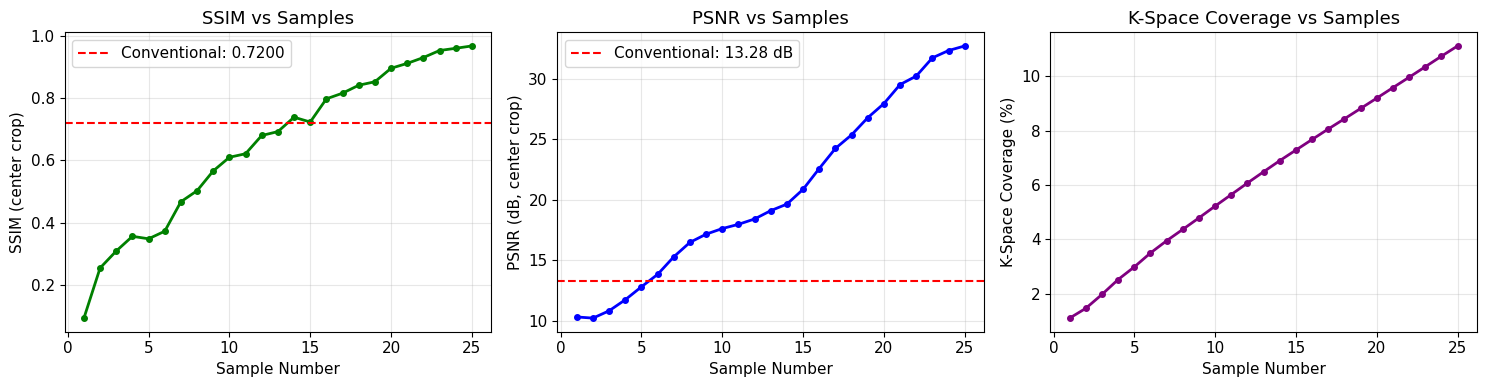


Metrics computed on 128x128 center crop (excludes background)
  SPIDS SSIM improvement: +0.2475
  SPIDS PSNR improvement: +19.44 dB


In [87]:
# Visualize training progress
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# SSIM progress
axes[0].plot(range(1, N_SAMPLES + 1), ssims_history, "g-o", linewidth=2, markersize=4)
axes[0].axhline(
    ssim_conventional, color="red", linestyle="--", label=f"Conventional: {ssim_conventional:.4f}"
)
axes[0].set_xlabel("Sample Number")
axes[0].set_ylabel("SSIM (center crop)")
axes[0].set_title("SSIM vs Samples")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PSNR progress
axes[1].plot(range(1, N_SAMPLES + 1), psnrs_history, "b-o", linewidth=2, markersize=4)
axes[1].axhline(
    psnr_conventional,
    color="red",
    linestyle="--",
    label=f"Conventional: {psnr_conventional:.2f} dB",
)
axes[1].set_xlabel("Sample Number")
axes[1].set_ylabel("PSNR (dB, center crop)")
axes[1].set_title("PSNR vs Samples")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Coverage progress
axes[2].plot(
    range(1, N_SAMPLES + 1),
    np.array(coverage_history) * 100,
    "purple",
    linewidth=2,
    marker="o",
    markersize=4,
)
axes[2].set_xlabel("Sample Number")
axes[2].set_ylabel("K-Space Coverage (%)")
axes[2].set_title("K-Space Coverage vs Samples")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(
    f"\nMetrics computed on {METRIC_CROP_SIZE}x{METRIC_CROP_SIZE} center crop (excludes background)"
)
print(f"  SPIDS SSIM improvement: {ssims_history[-1] - ssim_conventional:+.4f}")
print(f"  SPIDS PSNR improvement: {psnrs_history[-1] - psnr_conventional:+.2f} dB")

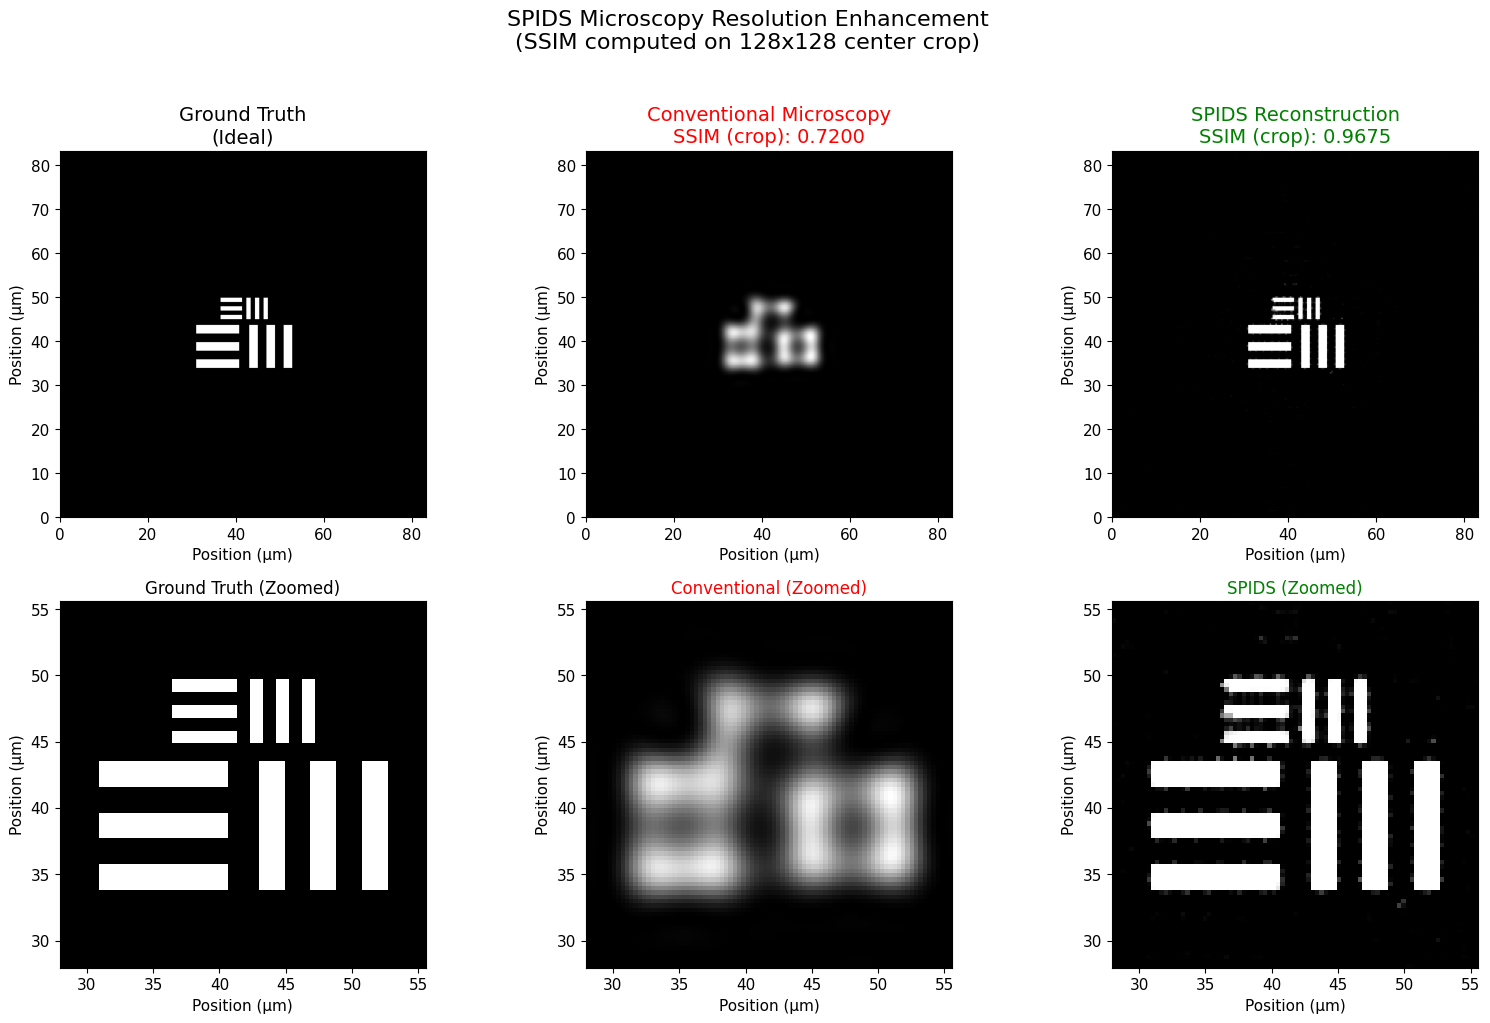

In [88]:
# =============================================================================
# FINAL COMPARISON: Ground Truth vs Conventional vs SPIDS
# =============================================================================

# Get final reconstruction
with torch.no_grad():
    final_reconstruction = model().squeeze().cpu().numpy()

# Normalize all images for comparison
gt_display = ground_truth.cpu().numpy()
conv_display = conventional_2d
spids_display = final_reconstruction

# Normalize
gt_display = (gt_display - gt_display.min()) / (gt_display.max() - gt_display.min())
conv_display = (conv_display - conv_display.min()) / (conv_display.max() - conv_display.min())
spids_display = (spids_display - spids_display.min()) / (spids_display.max() - spids_display.min())

# Create comparison figure
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Top row: Full images
axes[0, 0].imshow(gt_display, cmap="gray", extent=extent, origin="lower")
axes[0, 0].set_title("Ground Truth\n(Ideal)", fontsize=14)
axes[0, 0].set_xlabel("Position (µm)")
axes[0, 0].set_ylabel("Position (µm)")

axes[0, 1].imshow(conv_display, cmap="gray", extent=extent, origin="lower")
axes[0, 1].set_title(
    f"Conventional Microscopy\nSSIM (crop): {ssim_conventional:.4f}", fontsize=14, color="red"
)
axes[0, 1].set_xlabel("Position (µm)")
axes[0, 1].set_ylabel("Position (µm)")

axes[0, 2].imshow(spids_display, cmap="gray", extent=extent, origin="lower")
axes[0, 2].set_title(
    f"SPIDS Reconstruction\nSSIM (crop): {ssims_history[-1]:.4f}", fontsize=14, color="green"
)
axes[0, 2].set_xlabel("Position (µm)")
axes[0, 2].set_ylabel("Position (µm)")

# Bottom row: Zoomed regions (center crop) - this is where metrics are computed
crop_size = N_PIXELS // 3
start = N_PIXELS // 2 - crop_size // 2
end = start + crop_size
crop_extent = [
    extent[0] + start * object_pixel_size * 1e6,
    extent[0] + end * object_pixel_size * 1e6,
    extent[2] + start * object_pixel_size * 1e6,
    extent[2] + end * object_pixel_size * 1e6,
]

axes[1, 0].imshow(gt_display[start:end, start:end], cmap="gray", extent=crop_extent, origin="lower")
axes[1, 0].set_title("Ground Truth (Zoomed)", fontsize=12)
axes[1, 0].set_xlabel("Position (µm)")
axes[1, 0].set_ylabel("Position (µm)")

axes[1, 1].imshow(
    conv_display[start:end, start:end], cmap="gray", extent=crop_extent, origin="lower"
)
axes[1, 1].set_title("Conventional (Zoomed)", fontsize=12, color="red")
axes[1, 1].set_xlabel("Position (µm)")
axes[1, 1].set_ylabel("Position (µm)")

axes[1, 2].imshow(
    spids_display[start:end, start:end], cmap="gray", extent=crop_extent, origin="lower"
)
axes[1, 2].set_title("SPIDS (Zoomed)", fontsize=12, color="green")
axes[1, 2].set_xlabel("Position (µm)")
axes[1, 2].set_ylabel("Position (µm)")

plt.suptitle(
    f"SPIDS Microscopy Resolution Enhancement\n(SSIM computed on {METRIC_CROP_SIZE}x{METRIC_CROP_SIZE} center crop)",
    fontsize=16,
    y=1.02,
)
plt.tight_layout()
plt.show()

## 4.4 K-Space Analysis: Conventional vs SPIDS

Let's compare the k-space coverage and understand why SPIDS improves resolution.

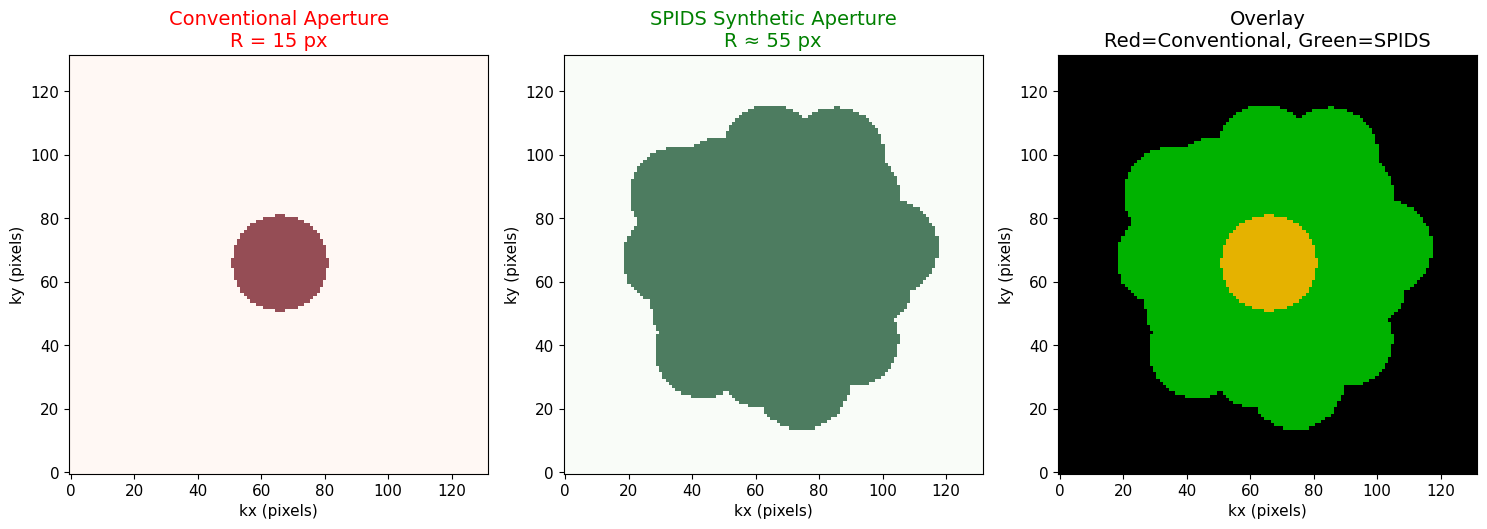


K-Space Coverage:
  Conventional: 1.09%
  SPIDS: 11.12%
  Enhancement: 10.2x more k-space coverage


In [89]:
# K-space visualization: Conventional small aperture vs SPIDS coverage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Get cumulative mask from measurement system
cum_mask = measurement_system.cum_mask.cpu().numpy()

# Create conventional small aperture mask (centered at DC)
conv_mask = (
    microscope.generate_aperture_mask([0, 0], radius=CONVENTIONAL_APERTURE_RADIUS).cpu().numpy()
)

# Center crop for visualization
crop = int(effective_synthetic_radius * 1.2)
center_crop = slice(N_PIXELS // 2 - crop, N_PIXELS // 2 + crop)

# Conventional small aperture
axes[0].imshow(conv_mask[center_crop, center_crop], cmap="Reds", origin="lower", alpha=0.7)
axes[0].set_title(
    f"Conventional Aperture\nR = {CONVENTIONAL_APERTURE_RADIUS:.0f} px", fontsize=14, color="red"
)
axes[0].set_xlabel("kx (pixels)")
axes[0].set_ylabel("ky (pixels)")

# SPIDS synthetic aperture
axes[1].imshow(cum_mask[center_crop, center_crop], cmap="Greens", origin="lower", alpha=0.7)
axes[1].set_title(
    f"SPIDS Synthetic Aperture\nR ≈ {effective_synthetic_radius:.0f} px", fontsize=14, color="green"
)
axes[1].set_xlabel("kx (pixels)")
axes[1].set_ylabel("ky (pixels)")

# Overlay comparison
overlay = np.zeros((*cum_mask[center_crop, center_crop].shape, 3))
overlay[..., 0] = conv_mask[center_crop, center_crop].astype(float) * 0.9  # Red: conventional
overlay[..., 1] = cum_mask[center_crop, center_crop].astype(float) * 0.7  # Green: SPIDS
axes[2].imshow(overlay, origin="lower")
axes[2].set_title("Overlay\nRed=Conventional, Green=SPIDS", fontsize=14)
axes[2].set_xlabel("kx (pixels)")
axes[2].set_ylabel("ky (pixels)")

plt.tight_layout()
plt.show()

# Calculate coverage statistics
conv_coverage = conv_mask.sum() / conv_mask.size
spids_coverage = cum_mask.sum() / cum_mask.size
coverage_ratio = spids_coverage / conv_coverage

print("\nK-Space Coverage:")
print(f"  Conventional: {conv_coverage * 100:.2f}%")
print(f"  SPIDS: {spids_coverage * 100:.2f}%")
print(f"  Enhancement: {coverage_ratio:.1f}x more k-space coverage")

In [90]:
# Delete unused cells by making them empty markdown
# This cell is replaced

---

# Part 5: Summary and Conclusions

In [91]:
# Final comparison metrics
print("\n" + "=" * 70)
print(" " * 15 + "RESULTS: CONVENTIONAL vs SPIDS")
print("=" * 70)

print("\n{:<30} {:>18} {:>18}".format("Metric", "Conventional", "SPIDS"))
print("-" * 70)

print("\nAPERTURE:")
print(
    "{:<30} {:>18.0f} {:>18.0f}".format(
        "Aperture radius (px)", CONVENTIONAL_APERTURE_RADIUS, SUB_APERTURE_RADIUS
    )
)
print("{:<30} {:>18} {:>18.0f}".format("Synthetic aperture (px)", "-", effective_synthetic_radius))
print(
    "{:<30} {:>18.2f} {:>18.2f}".format(
        "Effective NA", conventional_effective_na, synthetic_effective_na
    )
)
print(
    "{:<30} {:>18.0f} {:>18.0f}".format(
        "Resolution (nm)", conventional_resolution_nm, effective_resolution_nm
    )
)

print(f"\nIMAGE QUALITY (on {METRIC_CROP_SIZE}x{METRIC_CROP_SIZE} center crop):")
print("{:<30} {:>18.4f} {:>18.4f}".format("SSIM", ssim_conventional, ssims_history[-1]))
print("{:<30} {:>18.2f} {:>18.2f}".format("PSNR (dB)", psnr_conventional, psnrs_history[-1]))

improvement_ssim = (ssims_history[-1] - ssim_conventional) / ssim_conventional * 100
improvement_psnr = psnrs_history[-1] - psnr_conventional

print("\nIMPROVEMENT:")
print("{:<30} {:>18} {:>18}".format("SSIM change", "-", f"+{improvement_ssim:.1f}%"))
print("{:<30} {:>18} {:>18}".format("PSNR change", "-", f"+{improvement_psnr:.2f} dB"))
print("{:<30} {:>18} {:>18}".format("K-space coverage", "-", f"{coverage_ratio:.1f}x"))

print("\n" + "=" * 70)
print("Note: Metrics computed on center crop to exclude black background,")
print("providing more meaningful comparison of actual target features.")


               RESULTS: CONVENTIONAL vs SPIDS

Metric                               Conventional              SPIDS
----------------------------------------------------------------------

APERTURE:
Aperture radius (px)                           15                 15
Synthetic aperture (px)                         -                 55
Effective NA                                 0.10               0.36
Resolution (nm)                              3355                923

IMAGE QUALITY (on 128x128 center crop):
SSIM                                       0.7200             0.9675
PSNR (dB)                                   13.28              32.72

IMPROVEMENT:
SSIM change                                     -             +34.4%
PSNR change                                     -          +19.44 dB
K-space coverage                                -              10.2x

Note: Metrics computed on center crop to exclude black background,
providing more meaningful comparison of actual target fea

## Key Findings

### 1. SPIDS Uses the EXACT SAME Aperture as Conventional Microscopy
- Both methods use an aperture of radius R (determined by the objective NA)
- Conventional: aperture centered at DC (k=0)
- SPIDS: **same aperture** scanned to different k-space positions
- The aperture size is **NOT reduced** - this is the key insight!

### 2. Synthetic Aperture = Union of All Scan Positions
- Each scan position captures k-space content within radius R of that position
- The union of all positions covers a larger region than a single centered aperture
- Effective synthetic aperture radius ≈ scan_radius + aperture_radius
- By scanning to positions outside the original pupil, we capture frequencies that conventional imaging misses

### 3. Progressive Reconstruction Ensures Consistency
- Each measurement constrains the reconstruction at that k-space position
- The accumulated mask tracks all previously sampled k-space regions
- The model learns to match ALL measurements simultaneously

### 4. Physical Interpretation
| Method | K-space Coverage | Resolution |
|--------|-----------------|------------|
| Conventional | Circle of radius R at DC | λ/(2·NA) |
| SPIDS | Union of circles at different positions | λ/(2·NA_synthetic) |

The resolution improvement factor equals the ratio of synthetic to conventional aperture radii.

## Implementation

```python
# Conventional microscopy - aperture at DC
conventional_result = microscope.forward(target, aperture_center=[0, 0], 
                                         aperture_radius=PUPIL_RADIUS)

# SPIDS - SAME aperture, scanned to different positions
for center in scan_positions:
    measurement = microscope.forward(target, aperture_center=center, 
                                     aperture_radius=PUPIL_RADIUS)  # SAME radius!
```

The `aperture_radius` in SPIDS is **identical** to the conventional pupil radius.

In [92]:
# Final summary
print("\n" + "#" * 70)
print("#" + " " * 68 + "#")
print("#" + " " * 10 + "SPIDS MICROSCOPY RESOLUTION ENHANCEMENT COMPLETE" + " " * 9 + "#")
print("#" + " " * 68 + "#")
print("#" * 70)

print(f"""

SUMMARY
=======

Demonstrated SPIDS progressive reconstruction using the SAME aperture
as conventional microscopy, but scanned to build a larger synthetic aperture.

SETUP:
  Microscope: 20x / {na_low} NA objective
  Wavelength: {WAVELENGTH * 1e9:.0f} nm
  Aperture radius: {SYNTHETIC_APERTURE_RADIUS:.0f} px (SAME for both methods)

COMPARISON:
                        Conventional          SPIDS
  Aperture size:        {CONVENTIONAL_APERTURE_RADIUS:.0f} px               {SUB_APERTURE_RADIUS:.0f} px (SAME!)
  Aperture position:    DC only               Scanned ({N_SAMPLES} positions)
  Effective coverage:   {CONVENTIONAL_APERTURE_RADIUS:.0f} px radius        {effective_synthetic_radius:.0f} px radius
  Effective NA:         {conventional_effective_na:.2f}                {synthetic_effective_na:.2f}
  Resolution:           {conventional_resolution_nm:.0f} nm              {effective_resolution_nm:.0f} nm

RESULTS (on {METRIC_CROP_SIZE}x{METRIC_CROP_SIZE} center crop):
  SSIM: {ssim_conventional:.4f} -> {ssims_history[-1]:.4f} ({improvement_ssim:+.1f}%)
  PSNR: {psnr_conventional:.2f} dB -> {psnrs_history[-1]:.2f} dB ({improvement_psnr:+.2f} dB)
  K-space coverage: {coverage_ratio:.1f}x improvement

KEY INSIGHT: SPIDS uses the EXACT SAME aperture as conventional microscopy.
The resolution improvement comes from scanning the aperture to different
k-space positions, thereby capturing higher spatial frequencies that would
otherwise be blocked.

NOTE: Metrics are computed on center crop to exclude black background,
giving a more honest assessment of reconstruction quality on actual features.

""")

print(f"Completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


######################################################################
#                                                                    #
#          SPIDS MICROSCOPY RESOLUTION ENHANCEMENT COMPLETE         #
#                                                                    #
######################################################################


SUMMARY

Demonstrated SPIDS progressive reconstruction using the SAME aperture
as conventional microscopy, but scanned to build a larger synthetic aperture.

SETUP:
  Microscope: 20x / 0.1 NA objective
  Wavelength: 550 nm
  Aperture radius: 55 px (SAME for both methods)

COMPARISON:
                        Conventional          SPIDS
  Aperture size:        15 px               15 px (SAME!)
  Aperture position:    DC only               Scanned (25 positions)
  Effective coverage:   15 px radius        55 px radius
  Effective NA:         0.10                0.36
  Resolution:           3355 nm              923 nm

RESULTS (on 128x128 